In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,WeightedRandomSampler
from transformers import BertModel, BertConfig,BertTokenizerFast, BertForSequenceClassification, AdamW,DistilBertModel, DistilBertTokenizerFast
import mlflow
from dataloader import NlpTrainDataset,NlpTestDataset,WeightedSubsetRandomSampler
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR
from torch.optim import Adam
from focal import FocalLoss, LinkedFocalLoss
from train import learn
from logger import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from crossentropy import HardNegCrossEntropy,LinkedCrossEntropy,LinkedHardNegCrossEntropy
from tricks import seed_everything
from model import BERT_clf
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed_everything()

In [3]:
DATA_PATH = "data"
train_df = pd.read_json(DATA_PATH+"/train.json")
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv")
train_df['gender'] = train_df.apply(lambda x: 1 if x['gender'] == 'M' else 0,axis=1)
test_df['gender'] = test_df.apply(lambda x: 1 if x['gender'] == 'M' else 0,axis=1)

train_df['description'] = train_df['description'].apply(lambda x : x.lower())
test_df['description'] = test_df['description'].apply(lambda x : x.lower())

In [4]:
train, val, train_labels, val_labels = train_test_split(train_df,train_label['Category'],test_size=0.2,stratify=train_label['Category'],random_state=7,shuffle=True)

In [5]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased')
# bert = DistilBertModel.from_pretrained("distilbert-base-uncased")


In [6]:
# weight = train_labels
# curr = pd.DataFrame(weight.value_counts())
# curr.columns = ['weights']
# curr['Category'] = curr.index
# curr.loc[curr['Category']== 0,'weights'] *= 1.36
# curr.loc[curr['Category']== 3,'weights'] *= 1.34
# curr.loc[curr['Category']== 17,'weights'] *= 1.39
# tmp = pd.DataFrame(train_labels)
# df_sample = tmp.merge(curr,on='Category',how='left')
# df_sample.index = tmp.index
# df_sample['weights'] = df_sample['weights'].apply(lambda x: 1/x)

In [7]:
train_dataset = NlpTrainDataset(train,train_labels,tokenizer)
val_dataset = NlpTrainDataset(val,val_labels,tokenizer)

In [8]:
# optimizer = Adam([{'params': model.bert.parameters(),'lr':lr}],lr=lr_clf,eps=eps)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 2
batch_size = 32
lr = 2e-5
lr_clf = None
eps = 1e-8
alpha = None
gamma = None
gamma_scheduler = None
freeze = False
# link = {0:[3,19],3:[19,0,2], 7: [24], 11: [19], 23: [26], 24: [13,19],13:[24],17:[11],23:[26],2:[3]}
link = {0:[3,19],3:[19], 7: [24],17:[11],23:[26],2:[3],24:[13]}
alpha_link = 3
optimizer_name = 'AdamW'
top_k = None
loss_name = 'LinkedCrossEntropy'
scheduler_name = 'get_linear_schedule_with_warmup'
model = BERT_clf(bert,freeze = freeze)
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True,num_labels=28)
model = model.to(device)
no_decay = ['bias', 'LayerNorm.weight']
lr_layerdecay = None




# optimizer_grouped_parameters = [
#     {'params': model.bert.embeddings.parameters(), 'lr': lr * (lr_layerdecay ** 12)},
#     {'params': model.fc1.parameters(), 'lr': lr},
#     {'params': model.bert.pooler.parameters(), 'lr': lr}
# ]

# for layer in range(12):
#     optimizer_grouped_parameters.append(
#         {'params': model.bert.encoder.layer.__getattr__('%d' % (12- 1 - layer)).parameters(),
#          'lr': lr * (lr_layerdecay ** layer)},
#     )


optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
#optimizer = Adam(model.parameters(),lr=lr,eps=eps)
#loss_function = FocalLoss(alpha=alpha,gamma=gamma)
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels.values)
# weights= torch.tensor(class_weights,dtype=torch.float)
# weights = weights.to(device) 
#loss_function  = nn.CrossEntropyLoss()
# loss_function = HardNegCrossEntropy(top_k=top_k)
loss_function = LinkedCrossEntropy(alpha_link, link)
#loss_function = LinkedHardNegCrossEntropy(alpha_link, link,top_k)
# train_sampler = WeightedRandomSampler(df_sample['weights'].values, len(df_sample['weights'].values))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=1)
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1*total_steps)


#scheduler = StepLR(optimizer,  step_size=1, gamma=gamma_scheduler)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = num_warmup_steps,
                                            num_training_steps = total_steps)
tolerance = 20
delta = 0.0005
early_stopper = EarlyStopping(tolerance,delta)

comment = 'layer_decay'
hyperparameters = {'epochs':epochs,'batch_size': batch_size, 'lr':lr,'lr_clf':lr_clf, 'eps':eps,
                   'alpha': alpha, 'gamma': gamma, 'optimizer': optimizer_name,
                   'loss': loss_name,'scheduler':scheduler_name,
                   'tolerance_es': tolerance,'delta_es':delta,'gamma_scheduler':gamma_scheduler,'top_k':top_k,
                   'num_warmup': num_warmup_steps,'lr_layer_decay':lr_layerdecay,'freeze':freeze,
                   'alpha_link':alpha_link,'comment':comment}

modules= {'model':model,'optimizer':optimizer,'scheduler':scheduler,
          'loss_function':loss_function,'device': device,'early_stopper':early_stopper}


In [ ]:
learn(train_dataloader, val_dataloader, modules, hyperparameters, experiment_name="seed")


 Epoch 1 / 2
  Batch    50  of  5,430.
  Batch   100  of  5,430.
  Batch   150  of  5,430.
  Batch   200  of  5,430.
  Batch   250  of  5,430.
  Batch   300  of  5,430.
  Batch   350  of  5,430.
  Batch   400  of  5,430.
  Batch   450  of  5,430.
  Batch   500  of  5,430.
  Batch   550  of  5,430.
  Batch   600  of  5,430.
  Batch   650  of  5,430.
  Batch   700  of  5,430.
  Batch   750  of  5,430.
  Batch   800  of  5,430.
  Batch   850  of  5,430.
  Batch   900  of  5,430.
  Batch   950  of  5,430.
  Batch 1,000  of  5,430.
  Batch 1,050  of  5,430.
  Batch 1,100  of  5,430.
  Batch 1,150  of  5,430.
  Batch 1,200  of  5,430.
  Batch 1,250  of  5,430.
  Batch 1,300  of  5,430.
  Batch 1,350  of  5,430.
  Batch 1,400  of  5,430.
  Batch 1,450  of  5,430.
  Batch 1,500  of  5,430.
  Batch 1,550  of  5,430.
  Batch 1,600  of  5,430.
  Batch 1,650  of  5,430.
  Batch 1,700  of  5,430.
  Batch 1,750  of  5,430.
  Batch 1,800  of  5,430.
  Batch 1,850  of  5,430.
  Batch 1,900  of  5,430

In [10]:
#load weights of best model
path = 'mlruns/4/b7f3758f573649999ffdca3d998ddd51/artifacts/model_checkpoint/data/model.pth'
model= torch.load(path)


In [11]:
model

BERT_clf(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [12]:
from tqdm import tqdm

In [13]:
total_preds = []
total_labels = []
for batch in tqdm(val_dataloader):
    preds = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
    total_labels.append(batch['labels'])
    del preds

100%|██████████| 1358/1358 [02:30<00:00,  9.00it/s]


In [14]:
y_pred = np.concatenate(total_preds)
labels = np.concatenate(total_labels)

In [15]:
preds = np.argmax(y_pred,axis=1)  
# labels = np.concatenate(total_labels)

In [16]:
from sklearn.metrics import f1_score

In [17]:
f1_score(labels,preds,average='macro')

0.8087536909560258

In [15]:
0.8212520671445632

0.8212520671445632

In [18]:
testdata = NlpTestDataset(test_df,tokenizer)
test_dataloader = DataLoader(testdata, batch_size=32)

In [19]:
total_preds = []
for batch in tqdm(test_dataloader):
    preds = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
    del preds

100%|██████████| 1697/1697 [03:07<00:00,  9.04it/s]


In [20]:
import matplotlib.pyplot as plt

In [21]:
preds = np.argmax(np.concatenate(total_preds),axis=1)

(array([  408.,     0.,   988.,     0.,   293.,     0.,  2155.,     0.,
          180.,     0.,  1123.,     0.,  3110.,     0.,   219.,     0.,
         1539.,     0.,     0.,   715.,     0.,   207.,     0.,  2703.,
            0.,   388.,     0.,   840.,     0.,  2949.,     0.,  1096.,
            0.,  1454.,     0.,   375.,     0.,     0.,  1020.,     0.,
        18192.,     0.,  3724.,     0.,   210.,     0.,  2439.,     0.,
          199.,     0.,  1521.,     0.,   902.,     0.,  4811.,     0.,
          540.]),
 array([ 0.        ,  0.47368421,  0.94736842,  1.42105263,  1.89473684,
         2.36842105,  2.84210526,  3.31578947,  3.78947368,  4.26315789,
         4.73684211,  5.21052632,  5.68421053,  6.15789474,  6.63157895,
         7.10526316,  7.57894737,  8.05263158,  8.52631579,  9.        ,
         9.47368421,  9.94736842, 10.42105263, 10.89473684, 11.36842105,
        11.84210526, 12.31578947, 12.78947368, 13.26315789, 13.73684211,
        14.21052632, 14.68421053, 15.157

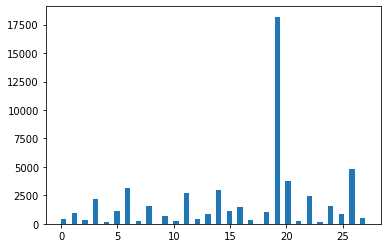

In [22]:
plt.hist(preds,bins='auto')

In [23]:
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['Category'] = preds
submission.to_csv('b7f3758f573649999ffdca3d998ddd51.csv',index=False)


In [23]:
submission

,Id,Category
3,0,6
6,1,20
11,2,19
17,3,19
18,4,19
...,...,...
271476,54295,19
271477,54296,12
271482,54297,19
271485,54298,26


In [8]:
from math import inf

/home/adil/anaconda3/envs/ma-gym/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
